# A simple example of generating playlist by multilable learning (toppush)

In [123]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os, sys, time
import pickle as pkl
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, f1_score, make_scorer, label_ranking_loss
from scipy.sparse import lil_matrix, issparse

import matplotlib.pyplot as plt
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [156]:
sys.path.append('src')
from TopPushMLC import TopPushMLC
from evaluate import evaluatePrecision, evalPred, avgPrecisionK
from BinaryRelevance import BinaryRelevance

In [3]:
data_dir = 'data'
faotm = os.path.join(data_dir, 'aotm-2011/aotm-2011-subset.pkl')
#fmap  = os.path.join(data_dir, 'aotm-2011/songID2TrackID.pkl')
ffeature = os.path.join(data_dir, 'msd/songID2Features.pkl')

In [16]:
fx      = os.path.join(data_dir, 'aotm-2011/X_audio.pkl')
fy      = os.path.join(data_dir, 'aotm-2011/Y_audio.pkl')
fxtrain = os.path.join(data_dir, 'aotm-2011/X_train_audio.pkl')
fytrain = os.path.join(data_dir, 'aotm-2011/Y_train_audio.pkl')
fxtest  = os.path.join(data_dir, 'aotm-2011/X_test_audio.pkl')
fytest  = os.path.join(data_dir, 'aotm-2011/Y_test_audio.pkl')

## Data loading

Load playlists.

In [5]:
playlists = pkl.load(open(faotm, 'rb'))

In [6]:
print('#Playlists: %d' % len(playlists))

#Playlists: 95298


In [7]:
playlists[0]

['SOFDPDC12A58A7D198',
 'SOPIEQP12A8C13F268',
 'SOKMCJK12A6D4F6105',
 'SOGTGJR12A6310E08D',
 'SOLTBYJ12A6310F2BB',
 'SOBOXXN12A6D4FA1A2',
 'SOUQUFO12B0B80778E']

In [8]:
#print('#Songs: %d' % len({songID for p in playlists for songID in p['filtered_lists'][0]}))

Average playlist length: 9.4


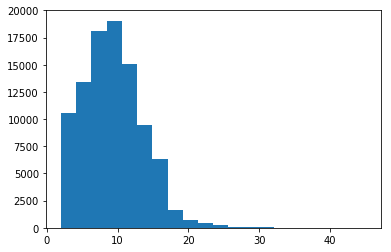

In [9]:
#lengths = [len(p['filtered_lists'][0]) for p in playlists]
lengths = [len(sl) for sl in playlists]
plt.hist(lengths, bins=20)
print('Average playlist length: %.1f' % np.mean(lengths))

Load `song_id` --> `track_id` mapping: a song may correspond to multiple tracks.

In [ ]:
#song2TrackID = pkl.load(open(fmap, 'rb'))

In [ ]:
#{ k : song2TrackID[k] for k in list(song2TrackID.keys())[:10] }

Load `song_id` --> `feature array` mapping: map a song to the audio features of one of its corresponding tracks in MSD.

In [10]:
song2Features = pkl.load(open(ffeature, 'rb'))

The set of songs, which is the set of labels in this formulation.

In [11]:
song_set = sorted(song2Features.keys())

In [12]:
len(song_set)

999056

In [13]:
label_indices = {songID: ix for ix, songID in enumerate(song_set)}

In [14]:
list(label_indices.items())[:10]

[('SOAAABI12A8C13615F', 0),
 ('SOAAABT12AC46860F0', 1),
 ('SOAAABX12A8C13FEB2', 2),
 ('SOAAACR12A58A79456', 3),
 ('SOAAACY12A58A79663', 4),
 ('SOAAADD12AB018A9DD', 5),
 ('SOAAADE12A6D4F80CC', 6),
 ('SOAAADF12A8C13DF62', 7),
 ('SOAAADP12A8C1413C7', 8),
 ('SOAAADZ12A8C1334FB', 9)]

In [101]:
def gen_training_set(playlists=playlists, label_indices=label_indices, features=song2Features):
    """
        Create the labelled dataset for a given song index
        
        Input:
            - playlists: which playlists to create features for
            - label_indices: a dictionary that maps a songID to the index of the corresponding label
            - features: a dictionary that maps a songID to its feature vector
            
        Output:
            - (Feature, Label) pair (X, Y), with # num playlists rows
              X comprises the features for each seed song
              Y comprises the indicators of whether the given song is present in the respective playlist
    """

    N = len(playlists)
    K = len(label_indices)

    X = [ ]
    Y = lil_matrix((N, K), dtype=np.int8)
    
    cnt = 0
    for i in range(len(playlists)):
        cnt += 1
        if cnt % 10 == 0:
            sys.stdout.write('\r%d / %d' % (cnt, len(playlists)))
            sys.stdout.flush()
            
        playlist = playlists[i]
        seed     = playlist[0]

        X.append(features[seed])
        #indices = [label_indices[s] for s in playlist]
        indices = [label_indices[s] for s in playlist if s in label_indices]
        Y[i, indices] = 1

    return np.array(X), Y.tocsr()

In [100]:
test_dict = {1: 0, 2: 1, 3: 2}
[test_dict[s] for s in [1, 2, 5] if s in test_dict]

[0, 1]

## Training & Test

Train a logistic regression model for each label.

In [17]:
if np.all([os.path.exists(fname) for fname in [fxtrain, fytrain, fxtest, fytest]]):
    X_train = pkl.load(open(fxtrain, 'rb'))
    Y_train = pkl.load(open(fytrain, 'rb'))
    X_test  = pkl.load(open(fxtest,  'rb'))
    Y_test  = pkl.load(open(fytest,  'rb'))
else:
    X, Y = gen_training_set(playlists=playlists, label_indices=label_indices, features=song2Features)
    # by fixing random seed, the same playlists will be in the test set each time
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=31)
    pkl.dump(X,       open(fx,      'wb'))
    pkl.dump(Y,       open(fy,      'wb'))
    pkl.dump(X_train, open(fxtrain, 'wb'))
    pkl.dump(Y_train, open(fytrain, 'wb'))
    pkl.dump(X_test,  open(fxtest,  'wb'))
    pkl.dump(Y_test,  open(fytest,  'wb'))

95290 / 95298

In [18]:
X_train.shape

(63849, 91)

In [19]:
X_test.shape

(31449, 91)

In [20]:
Y_train.shape

(63849, 999056)

In [21]:
Y_test.shape

(31449, 999056)

Feature normalisation.

In [22]:
X.shape

(95298, 91)

In [23]:
Y.shape

(95298, 999056)

In [84]:
songcnts = np.asarray(Y.sum(axis=0).tolist()[0])

In [85]:
np.max(songcnts)

828

In [86]:
indices = np.argsort(songcnts)

In [87]:
indices = np.asarray(indices[::-1])

In [90]:
songcnts[indices[0]]

828

In [89]:
songcnts[indices[-1]]

0

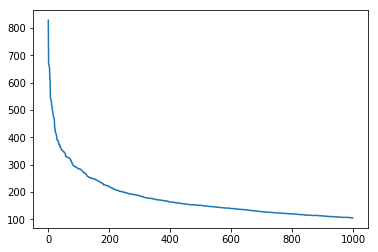

In [92]:
size=1000
plt.plot(np.arange(size), songcnts[indices[:size]])

### Type1 songs: the most populary songs

In [95]:
type1_songs = np.asarray(song_set)[indices[:200]]

In [102]:
type1_song_features = {sid: song2Features[sid] for sid in type1_songs}

In [104]:
type1_song_label_indices = {sid: ix for ix, sid in enumerate(type1_songs)}

In [110]:
playlist_subset = [pl for pl in playlists if pl[0] in type1_song_label_indices]

In [136]:
X1, Y1 = gen_training_set(playlists=playlist_subset, label_indices=type1_song_label_indices, \
                          features=type1_song_features)

6580 / 6589

Fitering out playlists with only one song.

In [137]:
Y1 = Y1.toarray()

In [138]:
ind1 = Y1.sum(axis=1) > 1

In [139]:
X1, Y1 = X1[ind1], Y1[ind1]

In [140]:
Y1.shape

(4078, 200)

Length histogram.

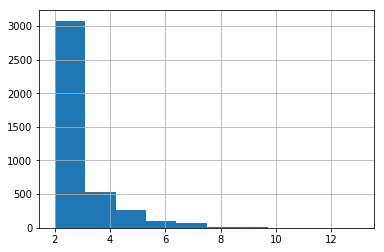

In [162]:
pd.Series(np.sum(Y1, axis=1)).hist()

Popularity histogram.

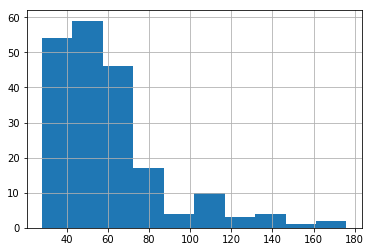

In [163]:
pd.Series(np.sum(Y1, axis=0)).hist()

In [141]:
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1, Y1, test_size=0.33, random_state=7)

In [142]:
X1_train_mean = np.mean(X1_train, axis=0).reshape((1, -1))
X1_train_std = np.std(X1_train, axis=0).reshape((1, -1)) + 10 ** (-6)
X1_train -= X1_train_mean
X1_train /= X1_train_std
X1_test  -= X1_train_mean
X1_test  /= X1_train_std

In [143]:
Y1_train.shape

(2732, 200)

Train.

In [144]:
ranges = range(-6, 7)
#ranges = range(-6, 5)
parameters = [{'C': sorted([10**(e) for e in ranges] + [3 * 10**(e) for e in ranges]),
               'r': [0.5, 1, 2, 4]}]
scorer = {'Prec': make_scorer(avgPrecisionK)}

In [146]:
clf1 = GridSearchCV(TopPushMLC(), parameters, scoring=scorer, cv=5, n_jobs=1, refit='Prec')
clf1.fit(X1_train, Y1_train)


C: 1e-06, r: 0.5

C: 1e-06, r: 0.5

C: 1e-06, r: 0.5

C: 1e-06, r: 0.5

C: 1e-06, r: 0.5

C: 1e-06, r: 1

C: 1e-06, r: 1

C: 1e-06, r: 1

C: 1e-06, r: 1

C: 1e-06, r: 1

C: 1e-06, r: 2

C: 1e-06, r: 2

C: 1e-06, r: 2

C: 1e-06, r: 2

C: 1e-06, r: 2

C: 1e-06, r: 4

C: 1e-06, r: 4

C: 1e-06, r: 4

C: 1e-06, r: 4

C: 1e-06, r: 4

C: 3e-06, r: 0.5

C: 3e-06, r: 0.5

C: 3e-06, r: 0.5

C: 3e-06, r: 0.5

C: 3e-06, r: 0.5

C: 3e-06, r: 1

C: 3e-06, r: 1

C: 3e-06, r: 1

C: 3e-06, r: 1

C: 3e-06, r: 1

C: 3e-06, r: 2

C: 3e-06, r: 2

C: 3e-06, r: 2

C: 3e-06, r: 2

C: 3e-06, r: 2

C: 3e-06, r: 4

C: 3e-06, r: 4

C: 3e-06, r: 4

C: 3e-06, r: 4

C: 3e-06, r: 4

C: 1e-05, r: 0.5

C: 1e-05, r: 0.5

C: 1e-05, r: 0.5

C: 1e-05, r: 0.5

C: 1e-05, r: 0.5

C: 1e-05, r: 1

C: 1e-05, r: 1

C: 1e-05, r: 1

C: 1e-05, r: 1

C: 1e-05, r: 1

C: 1e-05, r: 2

C: 1e-05, r: 2

C: 1e-05, r: 2

C: 1e-05, r: 2

C: 1e-05, r: 2

C: 1e-05, r: 4

C: 1e-05, r: 4

C: 1e-05, r: 4

C: 1e-05, r: 4

C: 1e-05, r: 4

C: 3e-05,

GridSearchCV(cv=5, error_score='raise',
       estimator=TopPushMLC(C=1, r=1, weighting=True), fit_params=None,
       iid=True, n_jobs=1,
       param_grid=[{'C': [1e-06, 3e-06, 1e-05, 3.0000000000000004e-05, 0.0001, 0.00030000000000000003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.30000000000000004, 1, 3, 10, 30, 100, 300, 1000, 3000, 10000, 30000, 100000, 300000, 1000000, 3000000], 'r': [0.5, 1, 2, 4]}],
       pre_dispatch='2*n_jobs', refit='Prec', return_train_score='warn',
       scoring={'Prec': make_scorer(avgPrecisionK)}, verbose=0)

In [159]:
br1 = GridSearchCV(BinaryRelevance(), param_grid=[{'C': parameters[0]['C']}], scoring=scorer, \
                   cv=5, n_jobs=4, refit='Prec')
br1.fit(X1_train, Y1_train)

GridSearchCV(cv=5, error_score='raise', estimator=BinaryRelevance(C=1),
       fit_params=None, iid=True, n_jobs=4,
       param_grid=[{'C': [1e-06, 3e-06, 1e-05, 3.0000000000000004e-05, 0.0001, 0.00030000000000000003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.30000000000000004, 1, 3, 10, 30, 100, 300, 1000, 3000, 10000, 30000, 100000, 300000, 1000000, 3000000]}],
       pre_dispatch='2*n_jobs', refit='Prec', return_train_score='warn',
       scoring={'Prec': make_scorer(avgPrecisionK)}, verbose=0)

In [148]:
print('TP1:')
evaluatePrecision(Y1_test, clf1.decision_function(X1_test))

TP1:


{'Precision@10': (0.12622585438335809, 0.0016752029185570598),
 'Precision@3': (0.36131748390292229, 0.0026385006146139177),
 'Precision@5': (0.22689450222882612, 0.0020517066762915956),
 'Precision@K': (0.41524985044673002, 0.0038298630526794825)}

In [160]:
print('BR1:')
evaluatePrecision(Y1_test, br1.decision_function(X1_test))

BR1:


{'Precision@10': (0.1272659732540862, 0.0017021868894834791),
 'Precision@3': (0.36057454185240218, 0.0027016317092426016),
 'Precision@5': (0.22778603268945025, 0.0022090257657996115),
 'Precision@K': (0.41553788790044366, 0.0038515756316768492)}

### Type2 songs: popularities are somewhat uniform

In [164]:
type2_songs = np.asarray(song_set)[indices[200:400]]

In [165]:
type2_song_features = {sid: song2Features[sid] for sid in type2_songs}

In [166]:
type2_song_label_indices = {sid: ix for ix, sid in enumerate(type2_songs)}

In [167]:
playlist_subset2 = [pl for pl in playlists if pl[0] in type2_song_label_indices]

In [168]:
X2, Y2 = gen_training_set(playlists=playlist_subset2, label_indices=type2_song_label_indices, \
                          features=type2_song_features)

4050 / 4052

Fitering out playlists with only one song.

In [169]:
Y2 = Y2.toarray()

In [170]:
ind2 = Y2.sum(axis=1) > 1

In [171]:
X2, Y2 = X2[ind2], Y2[ind2]

In [172]:
Y2.shape

(1663, 200)

Length histogram.

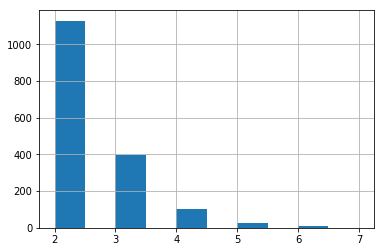

In [173]:
pd.Series(np.sum(Y2, axis=1)).hist()

Popularity histogram.

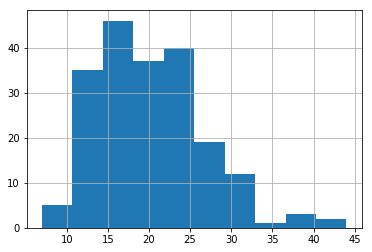

In [174]:
pd.Series(np.sum(Y2, axis=0)).hist()

In [175]:
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2, Y2, test_size=0.33, random_state=7)

In [176]:
X2_train_mean = np.mean(X2_train, axis=0).reshape((1, -1))
X2_train_std = np.std(X2_train, axis=0).reshape((1, -1)) + 10 ** (-6)
X2_train -= X2_train_mean
X2_train /= X2_train_std
X2_test  -= X2_train_mean
X2_test  /= X2_train_std

Train.

In [177]:
clf2 = GridSearchCV(TopPushMLC(), parameters, scoring=scorer, cv=5, n_jobs=1, refit='Prec')
clf2.fit(X2_train, Y2_train)


C: 1e-06, r: 0.5

C: 1e-06, r: 0.5

C: 1e-06, r: 0.5

C: 1e-06, r: 0.5

C: 1e-06, r: 0.5

C: 1e-06, r: 1

C: 1e-06, r: 1

C: 1e-06, r: 1

C: 1e-06, r: 1

C: 1e-06, r: 1

C: 1e-06, r: 2

C: 1e-06, r: 2

C: 1e-06, r: 2

C: 1e-06, r: 2

C: 1e-06, r: 2

C: 1e-06, r: 4

C: 1e-06, r: 4

C: 1e-06, r: 4

C: 1e-06, r: 4

C: 1e-06, r: 4

C: 3e-06, r: 0.5

C: 3e-06, r: 0.5

C: 3e-06, r: 0.5

C: 3e-06, r: 0.5

C: 3e-06, r: 0.5

C: 3e-06, r: 1

C: 3e-06, r: 1

C: 3e-06, r: 1

C: 3e-06, r: 1

C: 3e-06, r: 1

C: 3e-06, r: 2

C: 3e-06, r: 2

C: 3e-06, r: 2

C: 3e-06, r: 2

C: 3e-06, r: 2

C: 3e-06, r: 4

C: 3e-06, r: 4

C: 3e-06, r: 4

C: 3e-06, r: 4

C: 3e-06, r: 4

C: 1e-05, r: 0.5

C: 1e-05, r: 0.5

C: 1e-05, r: 0.5

C: 1e-05, r: 0.5

C: 1e-05, r: 0.5

C: 1e-05, r: 1

C: 1e-05, r: 1

C: 1e-05, r: 1

C: 1e-05, r: 1

C: 1e-05, r: 1

C: 1e-05, r: 2

C: 1e-05, r: 2

C: 1e-05, r: 2

C: 1e-05, r: 2

C: 1e-05, r: 2

C: 1e-05, r: 4

C: 1e-05, r: 4

C: 1e-05, r: 4

C: 1e-05, r: 4

C: 1e-05, r: 4

C: 3e-05,

GridSearchCV(cv=5, error_score='raise',
       estimator=TopPushMLC(C=1, r=1, weighting=True), fit_params=None,
       iid=True, n_jobs=1,
       param_grid=[{'C': [1e-06, 3e-06, 1e-05, 3.0000000000000004e-05, 0.0001, 0.00030000000000000003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.30000000000000004, 1, 3, 10, 30, 100, 300, 1000, 3000, 10000, 30000, 100000, 300000, 1000000, 3000000], 'r': [0.5, 1, 2, 4]}],
       pre_dispatch='2*n_jobs', refit='Prec', return_train_score='warn',
       scoring={'Prec': make_scorer(avgPrecisionK)}, verbose=0)

In [179]:
br2 = GridSearchCV(BinaryRelevance(), param_grid=[{'C': parameters[0]['C']}], scoring=scorer, \
                   cv=5, n_jobs=4, refit='Prec')
br2.fit(X2_train, Y2_train)

GridSearchCV(cv=5, error_score='raise', estimator=BinaryRelevance(C=1),
       fit_params=None, iid=True, n_jobs=4,
       param_grid=[{'C': [1e-06, 3e-06, 1e-05, 3.0000000000000004e-05, 0.0001, 0.00030000000000000003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.30000000000000004, 1, 3, 10, 30, 100, 300, 1000, 3000, 10000, 30000, 100000, 300000, 1000000, 3000000]}],
       pre_dispatch='2*n_jobs', refit='Prec', return_train_score='warn',
       scoring={'Prec': make_scorer(avgPrecisionK)}, verbose=0)

In [178]:
print('TP2:')
evaluatePrecision(Y2_test, clf2.decision_function(X2_test))

TP2:


{'Precision@10': (0.12258652094717667, 0.0025369994031851687),
 'Precision@3': (0.36065573770491804, 0.0051986715621653457),
 'Precision@5': (0.22732240437158469, 0.0039699218225547287),
 'Precision@K': (0.46170960187353627, 0.0067196452286968763)}

In [180]:
print('BR2:')
evaluatePrecision(Y2_test, br2.decision_function(X2_test))

BR2:


{'Precision@10': (0.1227686703096539, 0.002553596095736417),
 'Precision@3': (0.36126290224650881, 0.005298209757572489),
 'Precision@5': (0.22513661202185792, 0.0037564810806547874),
 'Precision@K': (0.46156214762772141, 0.0068056778922503747)}

In [ ]:
def print_results(predictor, X_train, Y_train, X_test, Y_test, trainPerf=False):
    """
        Compute and save performance results
    """
    batch_size = 500
    njobs = 16
    
    p3_test = []
    p5_test = []
    pk_test = []
    p10_test = []
    #rankloss_test = []
    
    N_test = X_test.shape[0]
    N_batch_test = int((N_test-1) / batch_size) + 1
    for i in range(N_batch_test):
        sys.stdout.write('\r%d / %d' % (i+1, N_batch_test)); sys.stdout.flush()
        ix0 = i * batch_size
        ix1 = min((i+1) * batch_size, N_test)
        preds = predictor.decision_function(X_test[ix0:ix1])
        evaldict = evaluatePrecision(Y_test[ix0:ix1].toarray(), preds, verbose=-1, n_jobs=njobs)
        size = ix1 - ix0
        p3_test.append(evaldict['Precision@3'][0] * size)
        p5_test.append(evaldict['Precision@5'][0] * size)
        pk_test.append(evaldict['Precision@K'][0] * size)
        p10_test.append(evaldict['Precision@10'][0] * size)
        #rankloss_test.append(evalPred1(Y_test[i].toarray()[0], pred, metricType='Ranking'))
    print()
    print('Test set:')
    print('Precision@3:', (np.sum(p3_test) / N_test))
    print('Precision@5:', (np.sum(p5_test) / N_test))
    print('Precision@k:', (np.sum(pk_test) / N_test))
    print('Precision@10:', (np.sum(p10_test) / N_test))
    print()
    
    if trainPerf is True:
        p3_train = []
        p5_train = []
        pk_train = []
        p10_train = []
        #rankloss_train = []

        N_train = X_train.shape[0]
        N_batch_train = int((N_train-1) / batch_size) + 1
        for i in range(N_batch_train):
            sys.stdout.write('\r%d / %d' % (i+1, N_batch_train)); sys.stdout.flush()
            ix0 = i * batch_size
            ix1 = min((i+1) * batch_size, N_train)
            preds = predictor.decision_function(X_train[ix0:ix1])
            evaldict = evaluatePrecision(Y_train[ix0:ix1].toarray(), preds, verbose=-1, n_jobs=njobs)
            size = ix1 - ix0
            p3_train.append(evaldict['Precision@3'][0] * size)
            p5_train.append(evaldict['Precision@5'][0] * size)
            pk_train.append(evaldict['Precision@K'][0] * size)
            p10_train.append(evaldict['Precision@10'][0] * size)
            #rankloss_train.append(evalPred1(Y_train[i].toarray()[0], pred, metricType='Ranking'))
        print()
        print('Training set:')
        print('Precision@3:', (np.sum(p3_train) / N_train))
        print('Precision@5:', (np.sum(p5_train) / N_train))
        print('Precision@k:', (np.sum(pk_train) / N_train))
        print('Precision@10:', (np.sum(p10_train) / N_train))
    
    #print()
    #print('Training set:')
    #print('RankingLoss: %.1f, %.1f' % (np.mean(rankloss_train), np.std(rankloss_train) / N_train))
    #print()
    #print('Test set:')
    #print('RankingLoss: %.1f, %.1f' % (np.mean(rankloss_test), np.std(rankloss_test) / N_test))

In [ ]:
def print_dataset_info(X_train, Y_train, X_test, Y_test):
    N_train, D = X_train.shape
    K = Y_train.shape[1]
    N_test = X_test.shape[0]
    print('%-45s %s' % ('Number of training examples:', '{:,}'.format(N_train)))
    print('%-45s %s' % ('Number of test examples:', '{:,}'.format(N_test)))
    print('%-45s %s' % ('Number of features:', '{:,}'.format(D)))
    print('%-45s %s' % ('Number of labels:', '{:,}'.format(K)))
    avgK_train = np.mean(np.sum(Y_train, axis=1))
    avgK_test  = np.mean(np.sum(Y_test, axis=1))
    print('%-45s %.3f (%.3f%%)' % ('Average number of positive labels (train):', avgK_train, 100*avgK_train / K))
    print('%-45s %.3f (%.3f%%)' % ('Average number of positive labels (test):', avgK_test, 100*avgK_test / K))
    #print('%-45s %.4f%%' % ('Average label occurrence (train):', np.mean(np.sum(Y_train, axis=0)) / N_train))
    #print('%-45s %.4f%%' % ('Average label occurrence (test):', np.mean(np.sum(Y_test, axis=0)) / N_test))
    print('%-45s %.3f%%' % ('Sparsity (percent) (train):', 100 * np.sum(Y_train) / np.prod(Y_train.shape)))
    print('%-45s %.3f%%' % ('Sparsity (percent) (test):', 100 * np.sum(Y_test) / np.prod(Y_test.shape)))

In [ ]:
print_dataset_info(X_train, Y_train, X_test, Y_test)

In [ ]:
clf_ = TopPushMLC(C=10000, r=2)
clf_.fit_SGD(X_train, Y_train, batch_size=500, n_epochs=10, learning_rate=0.05)

In [ ]:
print_results(clf_, X_train, Y_train, X_test, Y_test)